# What is  Code Vectorization?
Vectorized code refers to operations that are performed on multiple components of a vector at the same time instead of doing it iteratively(which is very slow when the problem size grows). Of course it does not mean it is easy or straightforward, but at least it does not necessitate totally rethinking your problem. Still, it may require some experience to see where code can be vectorized. Let's illustrate this through a simple example where we want to sum up two lists of integers. One simple way using pure Python is:

In [85]:
import time

array1 = list(range(1, 10000000))
array2 = list(range(1, 10000000))
start = time.time()
for i in range(len(array1)):
  array1[i] = array1[i] + array2[i]

end = time.time()

print("For loop time:", end - start)

For loop time: 1.4252934455871582


This first naive solution can be vectorized very easily using numpy:

In [86]:
import numpy as np

array1 = np.array(list(range(1, 10000000)))
array2 = np.array(list(range(1, 10000000)))

start = time.time()
result = np.add(array1, array2)
end = time.time()

print("Vectorization time:", end - start)

Vectorization time: 0.012635469436645508


## Helper Function(s) (Can Safely skip!)

In [87]:
def timeit(stmt, globals):
    '''
    Parameters
    ----------
    stmt - function to run
    globals - dictionary of current global variables

    Returns
    -------
    Nothing! Just prints relevant information about run-times.
    '''
    import timeit as _timeit
    import numpy as np

    # Rough approximation of a single run
    trial = _timeit.timeit(stmt, globals=globals, number=1)

    # Maximum duration
    duration = 1.0

    # Number of repeat
    repeat = 5

    # Compute rounded number of trials
    number = max(1,int(10**np.floor(np.log(duration/trial/repeat)/np.log(10))))

    # Only report best run
    best = min(_timeit.repeat(stmt, globals=globals, number=number, repeat=repeat))

    units = {"usec": 1, "msec": 1e3, "sec": 1e6}
    precision = 3
    usec = best * 1e6 / number
    if usec < 1000:
        print("%d loops, best of %d: %.*g usec per loop" % (number, repeat,
                                                            precision, usec))
    else:
        msec = usec / 1000
        if msec < 1000:
            print("%d loops, best of %d: %.*g msec per loop" % (number, repeat,
                                                                precision, msec))
        else:
            sec = msec / 1000
            print("%d loops, best of %d: %.*g sec per loop" % (number, repeat,
                                                                precision, sec))

# Uniform Vectorization
Uniform vectorization is the simplest form of vectorization where all the elements share the same computation at every time step with no specific processing for any element. One stereotypical case is the Game of Life that has been invented by John Conway.

The universe of the Game of Life is an infinite two-dimensional orthogonal grid of square cells, each of which is in one of two possible states, live or dead. Every cell interacts with its eight neighbours, which are the cells that are directly horizontally, vertically, or diagonally adjacent. At each step in time, the following transitions occur:

- Any live cell with fewer than two live neighbours dies, as if by needs caused by underpopulation.
- Any live cell with more than three live neighbours dies, as if by overcrowding.
- Any live cell with two or three live neighbours lives, unchanged, to the next generation.
- Any dead cell with exactly three live neighbours becomes a live cell.


## Iterative Method:Python
In pure Python, we can code the Game of Life using a list of lists representing the board where cells are supposed to evolve. Such a board will be equipped with border of 0 that allows to accelerate things a bit by avoiding having specific tests for borders when counting the number of neighbours.

In [88]:
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from matplotlib.patches import Rectangle

Taking the border into account, counting neighbours then is straightforward:

In [89]:
def compute_neighbours(Z: list) -> list:
  """
  Calculates the number of neighbours for each cell.

  Parameters
  ----------
  Z : list
      The array that represents the board
  """
  shape = len(Z), len(Z[0])
  N = [[0, ]*(shape[0]) for i in range(shape[1])]
  for x in range(1, shape[0]-1):
    for y in range(1, shape[1]-1):
      N[x][y] = (Z[x-1][y-1] + Z[x][y-1] + Z[x+1][y-1] + 
                Z[x-1][y] + Z[x+1][y] + Z[x-1][y+1] + 
                Z[x][y+1]+Z[x+1][y+1])
  return N

To iterate one step in time, we then simply count the number of neighbours for each internal cell and we update the whole board according to the four aforementioned rules:

In [90]:
def iterate_py(Z: list) -> list:
  """
  Count the number of neighbours for each internal cell and we update the whole board according to the four aforementioned rules.

  Parameters
  ----------
  Z : list
      The array that represents the board
  """
  shape = len(Z), len(Z[0])

  N = compute_neighbours(Z)
  for x in range(1, shape[0]-1):
    for y in range(1, shape[1]-1):
      if Z[x][y] == 1 and (N[x][y] < 2 or N[x][y] > 3): ## N[x][y]<2 refers to the underpopulation and N[x][y]>3 refers to the overcrowding rule
        Z[x][y] = 0 # Cell at (x,y) dies
      elif Z[x][y] == 0 and N[x][y] == 3: # Dead cell with 3 neighbours
        Z[x][y] = 1 # Becomes alive
  return Z

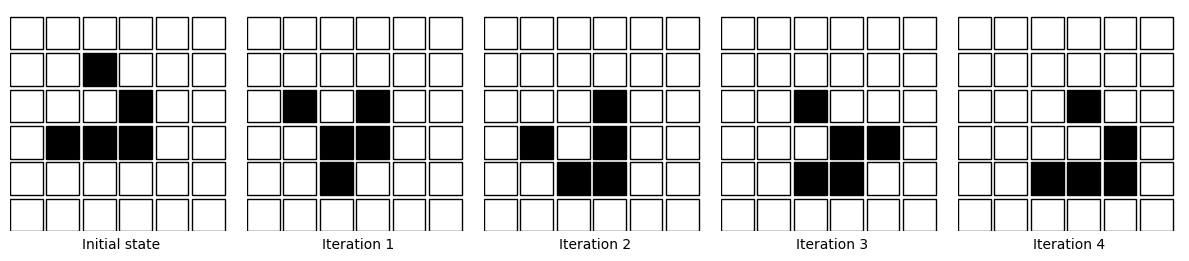

In [91]:
# Initialising the board of cells
Z = [[0, 0, 0, 0, 0, 0],
     [0, 0, 0, 1, 0, 0],
     [0, 1, 0, 1, 0, 0],
     [0, 0, 1, 1, 0, 0],
     [0, 0, 0, 0, 0, 0],
     [0, 0, 0, 0, 0, 0]]

figure = plt.figure(figsize=(12, 3))

labels = ("Initial state",
              "Iteration 1", "Iteration 2",
              "Iteration 3", "Iteration 4")

for i in range(5):
  ax = plt.subplot(1, 5, i+1, aspect=1, frameon=False)

  for x in range(6):
    for y in range(6):
      if Z[x][y] == 1:
        facecolor = 'black' # Black represents a cell being alive
      else:
        facecolor = 'white' # White represents a cell being dead
      rect = Rectangle((x, 5-y), width=0.9, height=0.9,
                                 linewidth=1.0, edgecolor='black',
                                 facecolor=facecolor)
      ax.add_patch(rect)
  ax.set_xlim(0, 6.1)
  ax.set_ylim(0, 6.1)
  ax.set_xticks([])
  ax.set_yticks([])
  ax.set_xlabel(labels[i])

  for tick in ax.xaxis.get_major_ticks():
    tick.tick1On = tick.tick2On = False
  for tick in ax.yaxis.get_major_ticks():
    tick.tick1On = tick.tick2On = False
  # Calling our iterate function
  iterate_py(Z)

plt.tight_layout()
plt.show()

## Vectorized Method: NumPy
Starting from the Python version, the vectorization of the Game of Life requires two parts, one responsible for counting the neighbours and one responsible for enforcing the rules. Neighbour-counting is relatively easy if we remember we took care of adding a null border around the arena. By considering partial views of the arena we can actually access neighbours quite intuitively as illustrated below for the one-dimensional case:

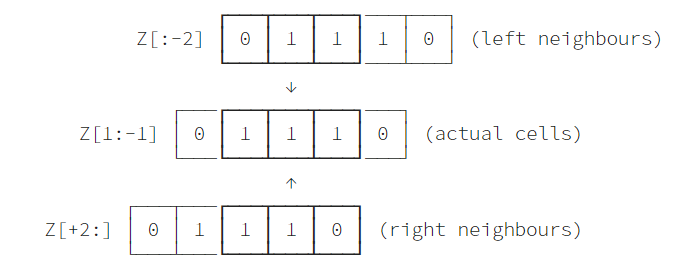

Going to the two dimensional case requires just a bit of arithmetic to make sure to consider all the eight neighbours. For the rule enforcement, we can factorize the rules into cells that will survive (stay at 1) and cells that will give birth. For doing this, we can take advantage of Numpy boolean capability and write quite naturally:

In [92]:
def iterate_numpy(Z):
  N = (Z[0:-2, 0:-2] + Z[0:-2, 1:-1] + Z[0:-2, 2:] +
         Z[1:-1, 0:-2]                 + Z[1:-1, 2:] +
         Z[2:  , 0:-2] + Z[2:  , 1:-1] + Z[2:  , 2:])
  birth = (N == 3) & (Z[1:-1, 1:-1] == 0)
  survive = ((N == 2) | (N == 3)) & (Z[1:-1, 1:-1] == 1)
  Z[...] = 0
  Z[1:-1, 1:-1][birth | survive] = 1

  return Z

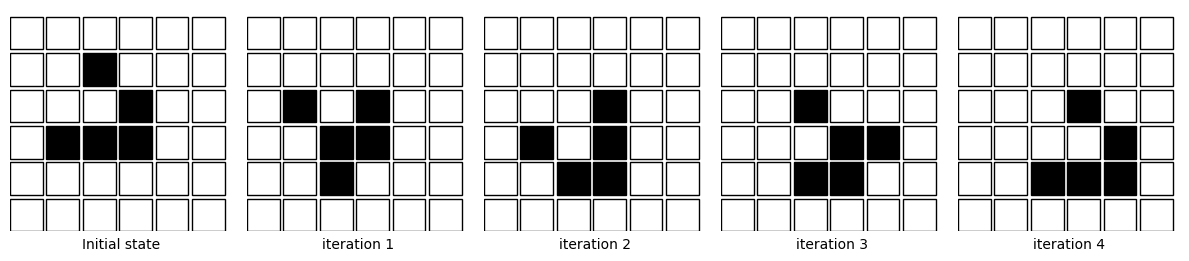

In [93]:
Z2 = [[0, 0, 0, 0, 0, 0],
     [0, 0, 0, 1, 0, 0],
     [0, 1, 0, 1, 0, 0],
     [0, 0, 1, 1, 0, 0],
     [0, 0, 0, 0, 0, 0],
     [0, 0, 0, 0, 0, 0]]
Z2 = np.array(Z2)
figure = plt.figure(figsize=(12, 3))

labels = ("Initial state",
              "iteration 1", "iteration 2",
              "iteration 3", "iteration 4")

for i in range(5):
  ax = plt.subplot(1, 5, i+1, aspect=1, frameon=False)

  for x in range(6):
    for y in range(6):
      if Z2[x][y] == 1:
        facecolor = 'black'
      else:
        facecolor = 'white'
      rect = Rectangle((x, 5-y), width=0.9, height=0.9,
                                 linewidth=1.0, edgecolor='black',
                                 facecolor=facecolor)
      ax.add_patch(rect)
  ax.set_xlim(0, 6.1)
  ax.set_ylim(0, 6.1)
  ax.set_xticks([])
  ax.set_yticks([])
  ax.set_xlabel(labels[i])

  for tick in ax.xaxis.get_major_ticks():
    tick.tick1On = tick.tick2On = False
  for tick in ax.yaxis.get_major_ticks():
    tick.tick1On = tick.tick2On = False
  iterate_numpy(Z2)

plt.tight_layout()
# plt.savefig("glider.png")
plt.show()

### Why is Vectorization Better?


In [94]:
Z = np.random.randint(0, 2, (300, 300))
Z1 = Z.copy()
timeit('iterate_py(Z)', globals())
timeit('iterate_numpy(Z1)', globals())

1 loops, best of 5: 186 msec per loop
100 loops, best of 5: 612 usec per loop


As you can see, simply by taking advantage of NumPy Vectorization, we were able to obtain a speedup of almost 300x !!!

As a fun little side project you can try to use FuncAnimation library to plot the Game of Life and watch the cells give birth and die for various initialisations of the board. It truly is remarkable!

## Thank you. <br>
Code for this notebook is borrowed and edited from [here](https://www.labri.fr/perso/nrougier/from-python-to-numpy/). Feel free to check the book out to explore vectorization in different contexts and examples. This small demo was made by [Aditya Kulkarni](https://github.com/AdiKul1294). Feel free to take a look at John Conway's Game of Life [here](https://web.archive.org/web/20090603015231/http://ddi.cs.uni-potsdam.de/HyFISCH/Produzieren/lis_projekt/proj_gamelife/ConwayScientificAmerican.htm).<br>
Copyright (2017) Nicolas P. Rougier - BSD license